In [1]:
#Importing the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout, Bidirectional
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
#Importing the dataset
df = pd.read_csv('BTC-USD.csv',index_col=0)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2022-06-26,21496.494141,21783.724609,21016.269531,21027.294922,21027.294922,18027170497
2022-06-27,21028.238281,21478.089844,20620.199219,20735.478516,20735.478516,20965695707
2022-06-28,20731.544922,21164.423828,20228.812500,20280.634766,20280.634766,21381535161


In [3]:
#Get the number of rows and columns in the data set
df.shape
df.iloc[df.values==-np.inf]
df =df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

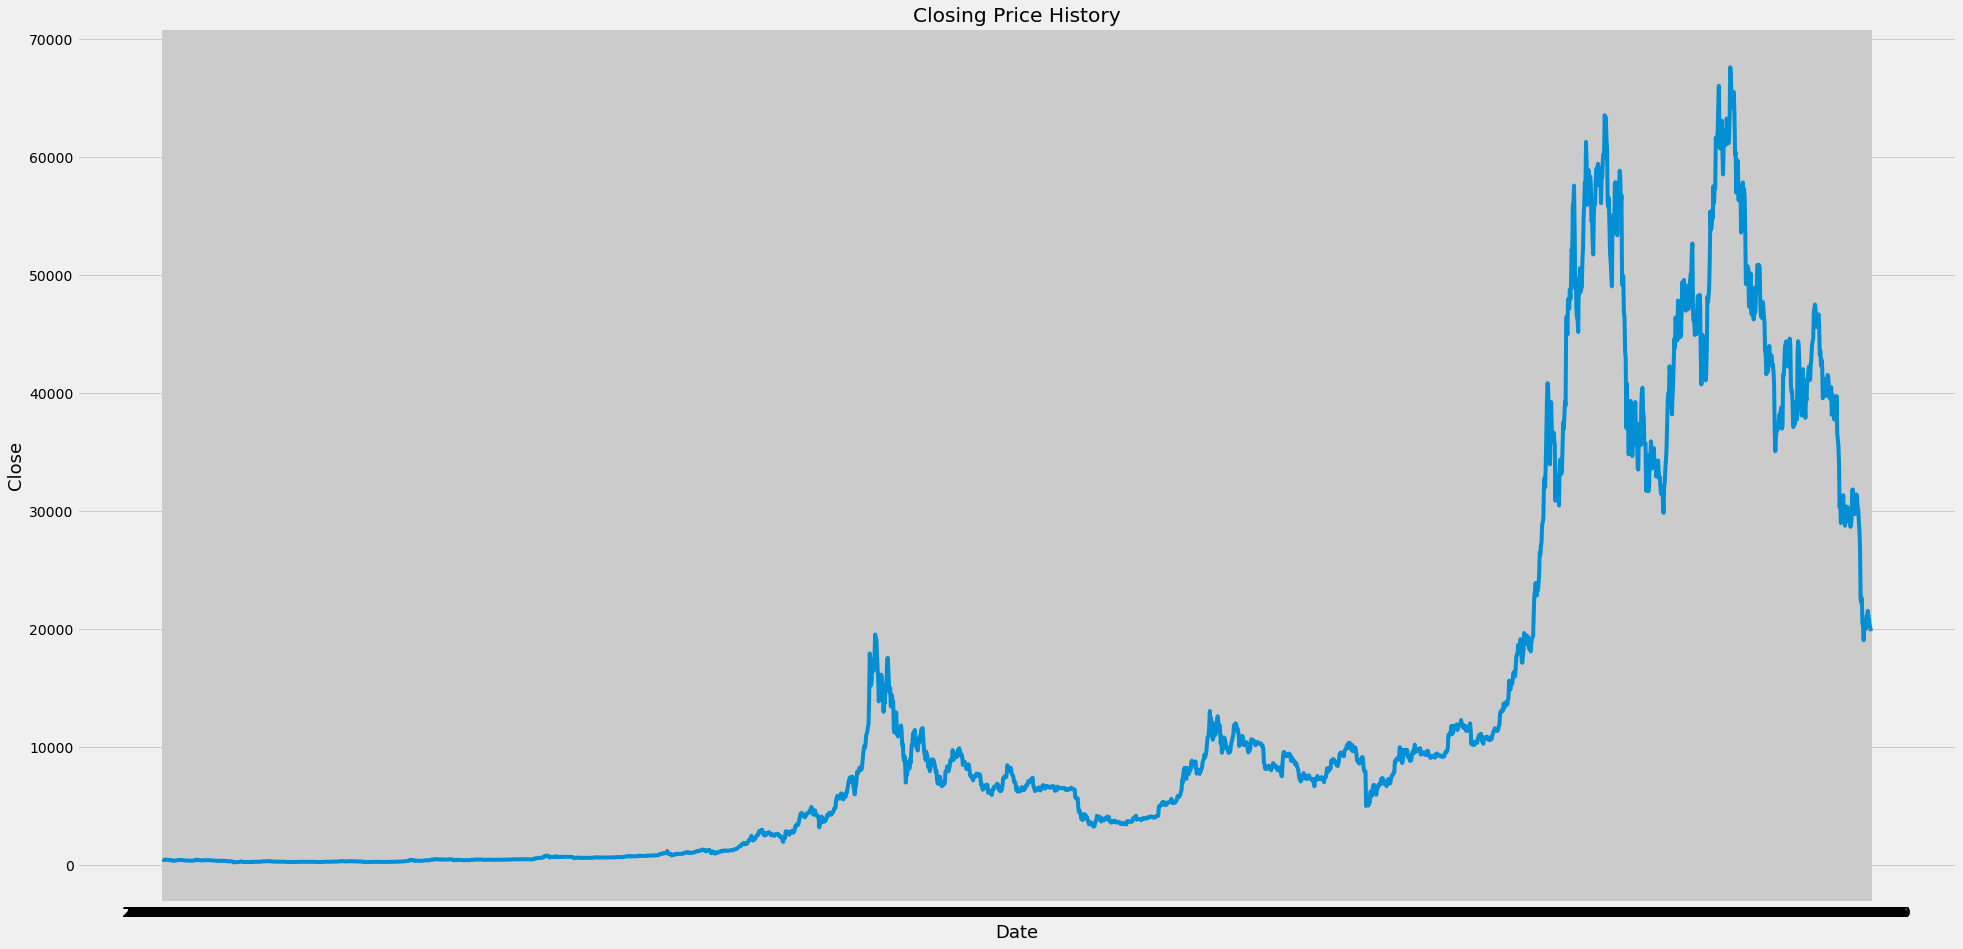

In [4]:
#Visualizing the closing price history
plt.figure(figsize=(30,15))
plt.title('Closing Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close', fontsize=18)
plt.show()

In [6]:
#Introducing relevant technical indicators 
import talib as tl

real = tl.RSI(df.Close, timeperiod=14)
df["RSI"] = real

EMA = pd.Series(df['Close'].ewm(span = 20, min_periods = 20 - 1).mean(), 
                 name = 'EWMA_' + str(20)) 
df["EWMA"] = EMA

macd, macdsignal, macdhist = tl.MACD(df.Close, fastperiod=12, slowperiod=26, signalperiod=9)
df["MACD"] = macd


In [7]:
#Removing the na values
df1 = df.dropna()
df1.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,EWMA,MACD
Date,,,,,,,,,
2014-10-20,389.230988,390.084015,378.252014,382.845001,382.845001,16419000,45.861098,379.435292,-6.216836
2014-10-21,382.420990,392.645996,380.834015,386.475006,386.475006,14188900,47.337013,380.126555,-5.196584
2014-10-22,386.118011,388.575989,382.248993,383.157990,383.157990,11641300,46.100267,380.423348,-4.602627
2014-10-23,382.962006,385.048004,356.446991,358.416992,358.416992,26456900,38.103741,378.274542,-6.058464
2014-10-24,358.591003,364.345001,353.304993,358.345001,358.345001,15585700,38.083041,376.333199,-7.135779


In [8]:
  #Create a new dataframe with only Close column
  data = df1.filter(['Close'])
  #Convert the dataframe to a numpy array
  dataset = data.values
  #Get number of rows to train the model
  training_data_len = math.ceil(len(dataset)*.9)
  training_data_len

2530

In [9]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data
scaled_data.shape

(2811, 1)

In [10]:
#Create training data set
#Cretae the scaled training data set
train_data = scaled_data[0:training_data_len, :]
#Split the data into X_train and Y_train data sets
x_train = []
y_train = []

for i in range(9, len(train_data)):
  x_train.append(train_data[i-9:i, 0])
  y_train.append(train_data[i, 0])
  if i <= 10:
    print(x_train)
    print(y_train)
    print()


[array([0.00303822, 0.00309209, 0.00304287, 0.00267573, 0.00267466,
       0.00251033, 0.00262063, 0.00259518, 0.00266387])]
[0.002337008241376624]

[array([0.00303822, 0.00309209, 0.00304287, 0.00267573, 0.00267466,
       0.00251033, 0.00262063, 0.00259518, 0.00266387]), array([0.00309209, 0.00304287, 0.00267573, 0.00267466, 0.00251033,
       0.00262063, 0.00259518, 0.00266387, 0.00233701])]
[0.002337008241376624, 0.0024811568356933886]



In [11]:
#Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [12]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2521, 9, 1)

In [44]:
#Building the LSTM model
DROPOUT = 0.2
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1))))
model.add(Dropout(rate=DROPOUT))
# model.add(Bidirectional(LSTM(50, return_sequences=True)))
# model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dropout(rate=DROPOUT))
model.add(Dense(25))
model.add(Dense(1))
model.add(Activation('linear'))

In [45]:
#Compile the model
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mean_squared_error')

In [74]:
#Train the model
model.fit(x_train, y_train, batch_size=25, epochs=8)

Epoch 1/8
101/101 [==============================] - 1s 10ms/step - loss: 4.9486e-04
Epoch 2/8
101/101 [==============================] - 1s 9ms/step - loss: 4.7332e-04
Epoch 3/8
101/101 [==============================] - 1s 10ms/step - loss: 4.8478e-04
Epoch 4/8
101/101 [==============================] - 1s 9ms/step - loss: 3.9925e-04
Epoch 5/8
101/101 [==============================] - 1s 10ms/step - loss: 3.6449e-04
Epoch 6/8
101/101 [==============================] - 1s 10ms/step - loss: 4.0405e-04
Epoch 7/8
101/101 [==============================] - 1s 9ms/step - loss: 6.8007e-04
Epoch 8/8
101/101 [==============================] - 1s 9ms/step - loss: 5.8077e-04


In [75]:
#Create the testing data set
#Create a new array containing scaled values from index 
test_data = scaled_data[training_data_len - 9: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(9, len(test_data)):
  x_test.append(test_data[i-9:i, 0])

In [76]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [77]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [78]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

9/9 [==============================] - 0s 5ms/step


In [80]:
#Get R^2 Score
from sklearn.metrics import r2_score
r2_score(y_test, predictions)

0.9719181309474685

In [81]:
#Get Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, predictions)

1428.4624735649468

C:\Users\PC\AppData\Local\Temp\ipykernel_1784\1967298145.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


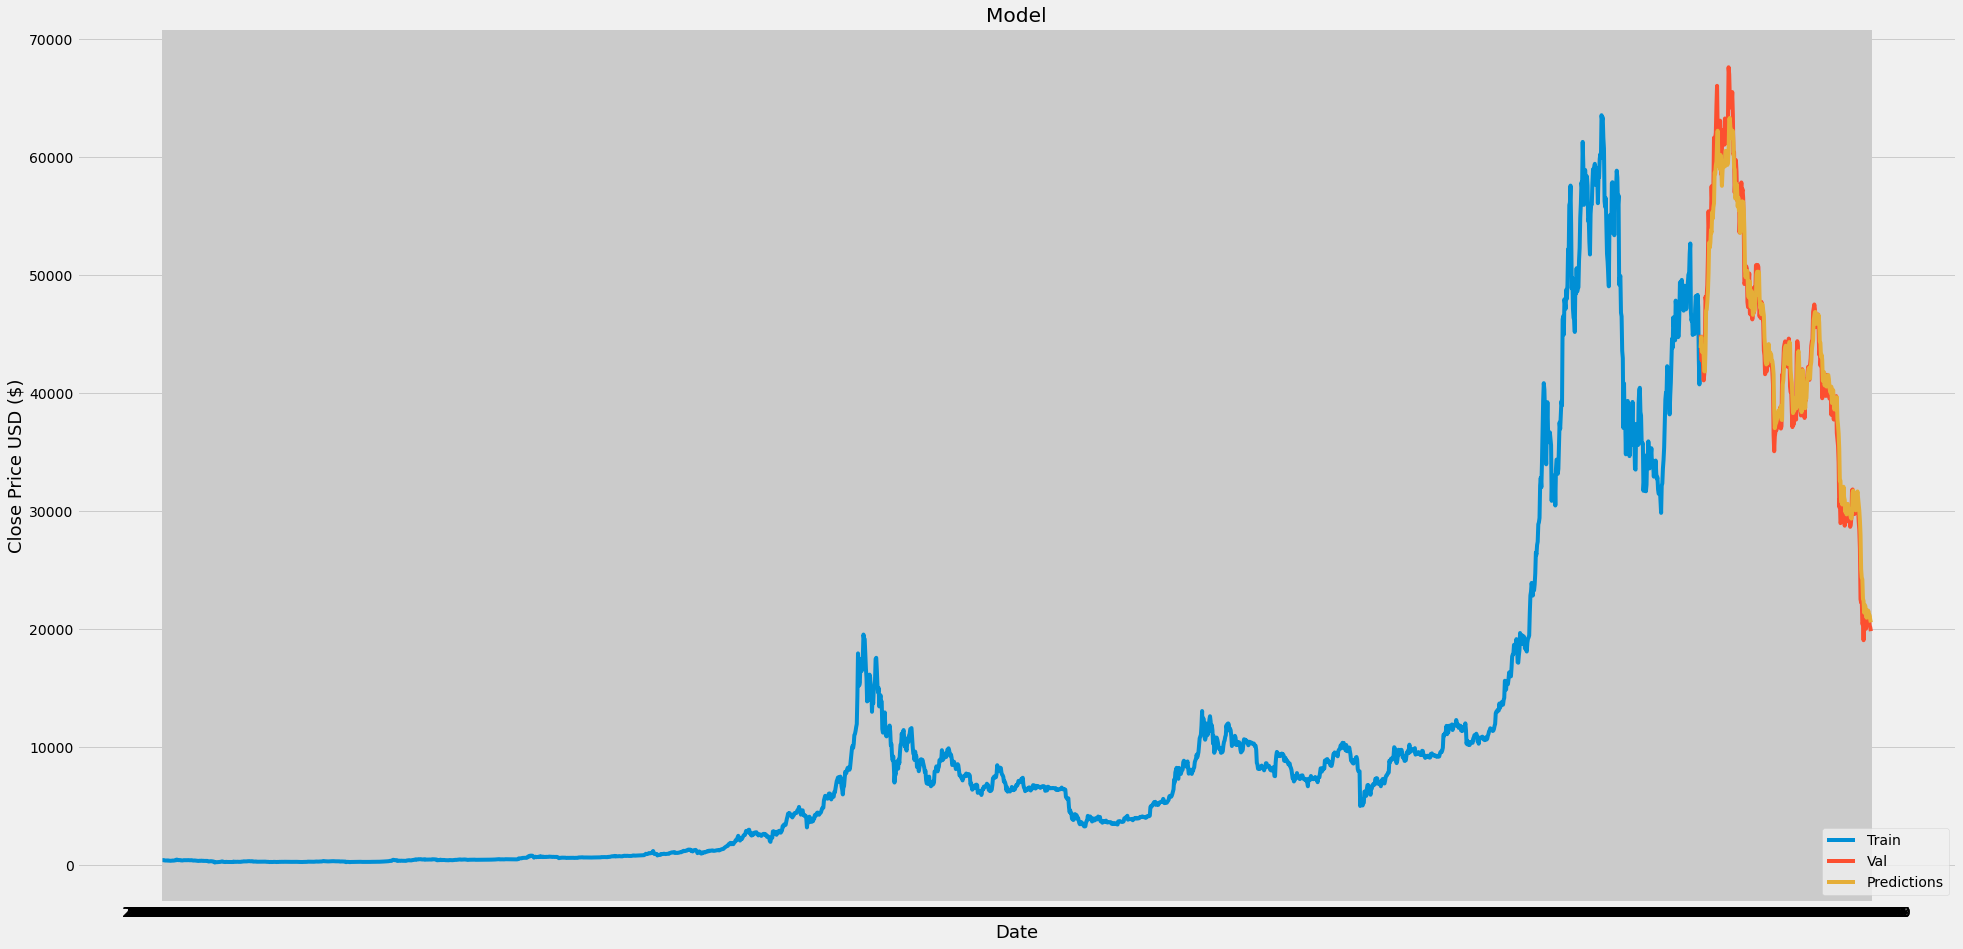

In [82]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(30,15))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'], loc='lower right')
predictions
plt.show()